# 03.0 - hyperparameters influence on random forest

This part of notebook investigates how selected hyperparameters influence the performance of the **Random Forest** model in predicting football match outcomes.

The target variable represents match results with three classes:
- **H** (Home win),
- **D** (Draw),
- **A** (Away win).

We analyze how tuning key hyperparameters affects the **macro F1-score** and **accuracy**, helping to understand which settings lead to better generalization and prediction quality.


In [1]:
import sys
from pathlib import Path

project_root = Path.cwd().parent
sys.path.append(str(project_root))

print("Project root added to sys.path:", project_root)

Project root added to sys.path: e:\.1\6 semestr\Podstawy sztucznej inteligencji\Projekt\football-prediction


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import f1_score, accuracy_score

from src.data_loader import load_data
from src.features import extract_features
from src.constants import FEATURE_COLUMNS
from src.model import _build_rf

## Data Preparation

We load the preprocessed match dataset, extract relevant features, and apply SMOTE to balance the training data.

In [6]:
input_path = Path.cwd().parent / "data" / "processed" / "model_input.parquet"

df = extract_features(load_data(input_path)).dropna(subset=FEATURE_COLUMNS + ["result"])
X, y = df[FEATURE_COLUMNS], df["result"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

## Evaluation Metrics

We use macro-averaged F1-score and accuracy to evaluate model performance. The macro F1 is especially useful here due to the class imbalance.


In [ ]:
def evaluate(model, X_test, y_test):
    y_pred = model.predict(X_test)
    return {
        "f1_macro": f1_score(y_test, y_pred, average="macro"),
        "accuracy": accuracy_score(y_test, y_pred)
    }

## Experiment Function

The function below trains a Random Forest model using different values of a chosen hyperparameter and records the corresponding performance metrics.


In [ ]:
from tqdm import tqdm

def run_rf_experiment(param_name, param_values, base_config=None):
    if base_config is None:
        base_config = {}

    results = []

    for val in tqdm(param_values):
        cfg = base_config.copy()
        cfg[param_name] = val
        model = _build_rf(cfg)
        model.fit(X_train_res, y_train_res)
        scores = evaluate(model, X_test, y_test)
        scores[param_name] = val
        results.append(scores)

    return pd.DataFrame(results)


## Ploting function for f1-macro and accuracy

In [11]:
def plot_results(df, param_name):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    sns.lineplot(data=df, x=param_name, y="f1_macro", marker="o", ax=axes[0])
    axes[0].set_title(f"Macro F1 vs {param_name}")
    axes[0].grid(True)

    sns.lineplot(data=df, x=param_name, y="accuracy", marker="o", ax=axes[1])
    axes[1].set_title(f"Accuracy vs {param_name}")
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()


## Experiment: N-estimators parameter

100%|██████████| 6/6 [00:13<00:00,  2.24s/it]


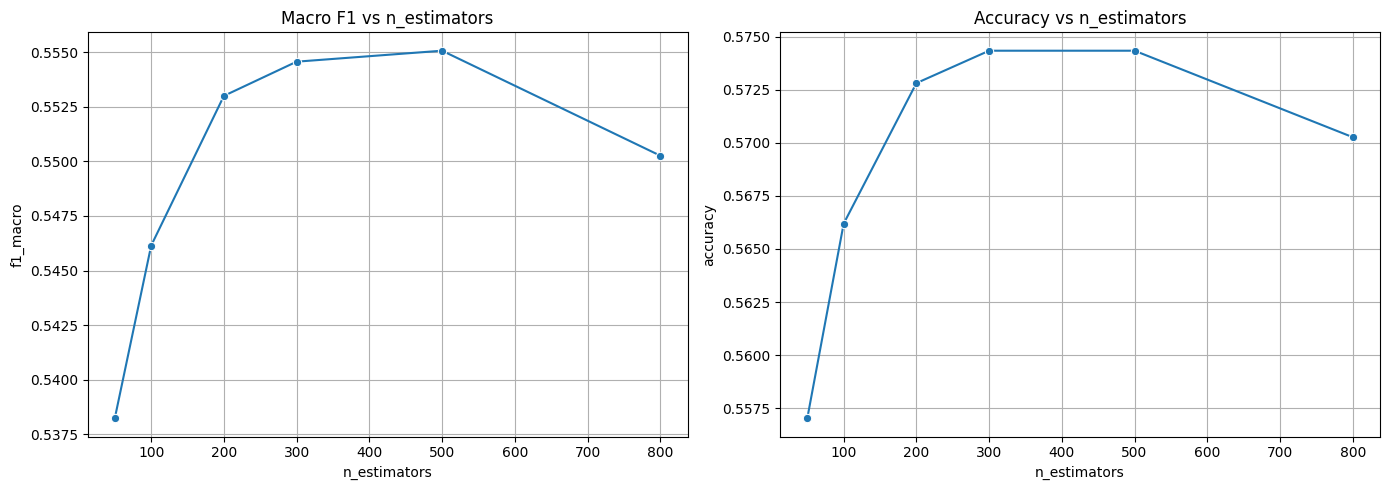

In [12]:
n_vals = [50, 100, 200, 300, 500, 800]
df_n = run_rf_experiment("n_estimators", n_vals)
plot_results(df_n, "n_estimators")


## Experiment: max_depth

The maximum depth of each tree. Higher values can model more complex patterns but may overfit.

100%|██████████| 7/7 [00:08<00:00,  1.19s/it]


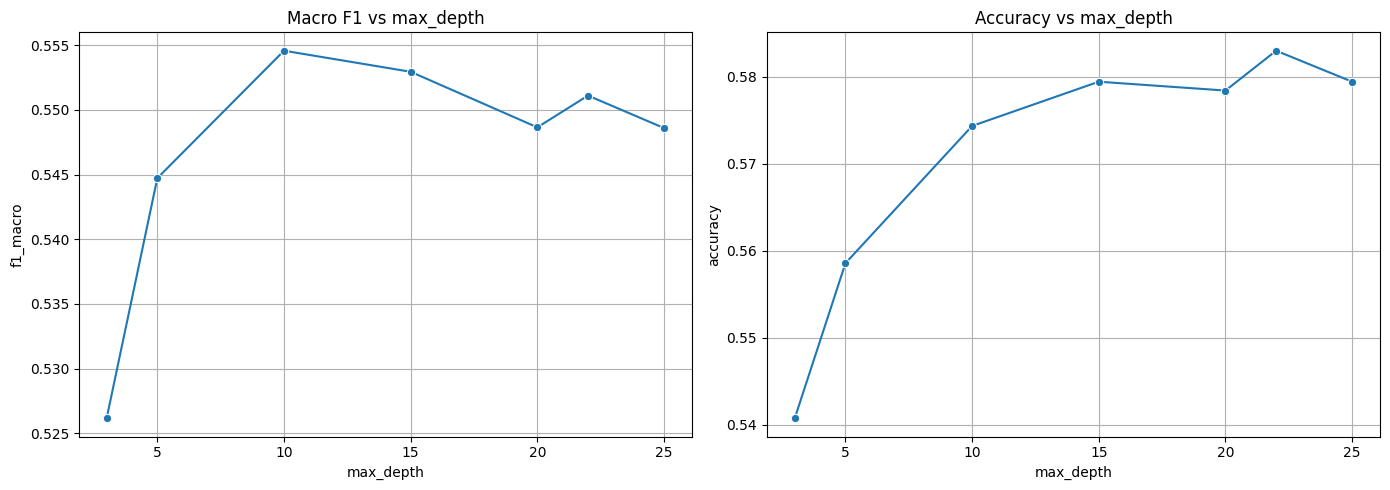

In [15]:
depth_vals = [3, 5, 10, 15, 20, 22, 25]

df_d = run_rf_experiment("max_depth", [v if v is not None else 100 for v in depth_vals])
df_d["max_depth"] = depth_vals
plot_results(df_d, "max_depth")

## Experiment: min_samples_leaf

The minimum number of samples required to be at a leaf node. Increasing this can reduce overfitting.


100%|██████████| 9/9 [00:10<00:00,  1.22s/it]


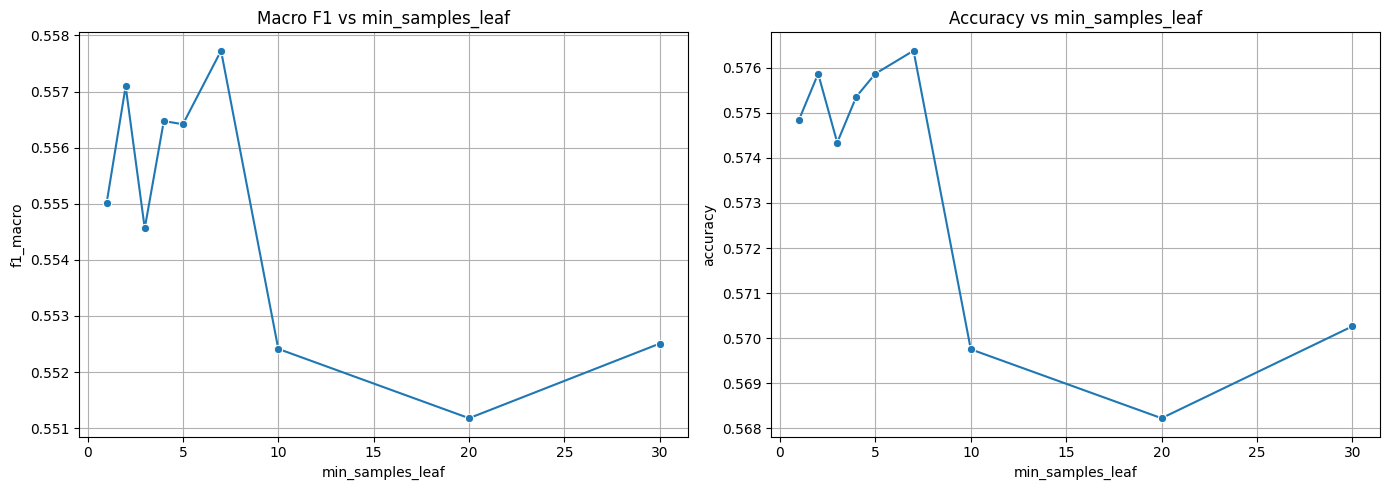

In [17]:
leaf_vals = [1, 2, 3, 4, 5, 7, 10, 20, 30]
df_l = run_rf_experiment("min_samples_leaf", leaf_vals)
plot_results(df_l, "min_samples_leaf")

## Summary and Takeaways

The impact of each hyperparameter can be summarized as:

- **n_estimators**: Performance improves as the number of trees increases, but saturates after ~500 trees.
- **max_depth**: Shallow trees (depth ≤ 5) underfit; very deep trees risk overfitting. A good trade-off is around 10-15.
- **min_samples_leaf**: A good trade-off is around 3-7.